# Concentration vs Extraction, Retraction, Recording, Patch Duration

In [1]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

from IPython.display import display #Found this to display all columns in a table

sns.set_style('whitegrid') #Makes a white backround with gray horizontal gridmarks at y-values
sns.set_context('notebook') #Formats style of plots

##### postpatch_func.py by Rusty from Stash 

In [2]:
def nucleated(x):
    nuc_high_seal = x[(x['Post patch?'] == 'Nucleated') | 
                      (((x['Post patch?'] == 'nucleus_visible') | 
                      (x['Post patch?'] == 'nucleus_present')) & 
                      (x['Post patch pipette R'] >= 500))]
    return nuc_high_seal

def partial_nucleated(y):
    nuc_low_seal = y[(y['Post patch?'] == 'Partial-Nucleus') | 
                     (((y['Post patch?'] == 'nucleus_present') | 
                     (y['Post patch?'] == 'nucleus_visible')) & 
                     (y['Post patch pipette R'] <= 499))]
    return nuc_low_seal

def outside_out(z):
    no_high_seal = z[(z['Post patch?'] == 'Outside-Out') | 
                     (((z['Post patch?'] == 'nucleus_absent') | 
                     (z['Post patch?'] == 'no_nucleus_visible')) & 
                     (z['Post patch pipette R'] >= 500))]
    return no_high_seal

def no_seal(w): 
    no_low_seal = w[(w['Post patch?'] == 'No-Seal') | 
                    (((w['Post patch?'] == 'nucleus_absent') | 
                    (w['Post patch?'] == 'no_nucleus_visible')) & 
                    (w['Post patch pipette R'] <= 499))]
    return no_low_seal
    
def entire_cell(v):
    entire = v[(v['Post patch?'] == 'Entire-Cell') | 
               (v['Post patch?'] == 'entire_cell')]
    return entire

#variable['post_patch'] = 'Term'
#Term is an output displayed in the Post_Patch column

def reclassify(df):
    nu = nucleated(df)
    nu['post_patch'] = 'Nuc-high seal' 
    oo = outside_out(df)
    oo['post_patch'] = 'No-high seal'
    pn = partial_nucleated(df)
    pn['post_patch'] = 'Nuc-low seal'
    ns = no_seal(df)
    ns['post_patch'] = 'No-low seal'
    ec = entire_cell(df)
    ec['post_patch'] = 'Entire cell'
    return  nu, oo, pn, ns, ec

def concat_df(a, b, c, d, e):
    frames = (a, b, c, d, e)
    df = pd.concat(frames)
    return df

def postpatch_reclass(df):
    return concat_df(*reclassify(df))

#ps_df = postpatch_reclass(ps_df)

##### Importing csv

In [3]:
ps_df = pd.read_csv("patch_seq_log_mouse.csv")

In [4]:
initial =["Lims tube id", 
          "Post patch?", 
          "Post patch pipette R", 
          "BA conc. >400 (pg/uL)",
          "Time spent extracting cytosol", 
          "Time spent retracting pipette",
          "patch duration",
          "PCR cycles", 
          "SM_QC_PF", 
          "Bad dates"]
ps_df = ps_df[initial]

##### Filtering & Sorting columns

In [5]:
#Changing String to Numerical
ps_df["Time spent extracting cytosol"] = pd.to_numeric(ps_df["Time spent extracting cytosol"].str.replace(' ',''), errors ='coerce')
ps_df["Time spent retracting pipette"] = pd.to_numeric(ps_df["Time spent retracting pipette"].str.replace(' ',''), errors ='coerce')
ps_df["patch duration"] = pd.to_numeric(ps_df["patch duration"].str.replace(' ',''), errors ='coerce')
ps_df["BA conc. >400 (pg/uL)"] = pd.to_numeric(ps_df["BA conc. >400 (pg/uL)"].str.replace(' ',''), errors ='coerce')

#Categories
ps_df["Post patch?"] = ps_df["Post patch?"].astype("category")
ps_df["PCR cycles"] = ps_df["PCR cycles"].astype("category")
ps_df["SM_QC_PF"] = ps_df["SM_QC_PF"].astype("category")
ps_df["Bad dates"] = ps_df["Bad dates"].astype("category")

#Filtering Columns
ps_df = ps_df[ps_df["PCR cycles"] == 21]      #Shows 21 pcr cycles
ps_df = ps_df[ps_df["SM_QC_PF"] != "cnt"]     #Shows everything except cnt
ps_df = ps_df[ps_df["Bad dates"] != "x"]      #Shows everthing except x
ps_df = ps_df[ps_df["Time spent extracting cytosol"] <= 10]
ps_df = ps_df[ps_df["BA conc. >400 (pg/uL)"] < 8000]

In [6]:
#Dropping blank columns
ps_df.dropna(subset = ["Post patch?", 
                       "Time spent extracting cytosol", 
                       "Time spent retracting pipette",
                       'patch duration',
                       "BA conc. >400 (pg/uL)", 
                       "SM_QC_PF"], inplace = True)
ps_df.head()

,Lims tube id,Post patch?,Post patch pipette R,BA conc. >400 (pg/uL),Time spent extracting cytosol,Time spent retracting pipette,patch duration,PCR cycles,SM_QC_PF,Bad dates
4019,P2S4_171002_053_A01,nucleus_absent,10.0,83.349,0.633333,3.316667,9.216667,21.0,fail,NaN
4020,P2S4_171002_054_A01,nucleus_present,1000.0,276.086,0.750000,1.583333,8.350000,21.0,pass,NaN
4021,P2S4_171002_055_A01,nucleus_present,1000.0,909.504,0.466667,1.950000,6.733333,21.0,pass,NaN
4022,P2S4_171002_056_A01,nucleus_absent,40.0,95.067,0.700000,6.333333,12.250000,21.0,fail,NaN
4026,P8S4_171002_354_A01,nucleus_present,1100.0,284.316,0.233333,2.150000,9.483333,21.0,pass,NaN


##### Creating rec_dur column

In [7]:
ps_df['rec_dur'] = ps_df['patch duration'] - ps_df['Time spent extracting cytosol'] - ps_df['Time spent retracting pipette']
ps_df = ps_df[ps_df['rec_dur'] > 0] #Only shows postive values

##### Creating Date Column

In [8]:
ps_df['Date'] = ps_df['Lims tube id'].str[5:11]

##### Set & Sort Date Index

In [9]:
ps_df = ps_df.set_index('Date')
ps_df = ps_df.sort_index()

##### Production Start Date

In [10]:
ps_df = ps_df['170901':]

In [11]:
ps_df.head()

,Lims tube id,Post patch?,Post patch pipette R,BA conc. >400 (pg/uL),Time spent extracting cytosol,Time spent retracting pipette,patch duration,PCR cycles,SM_QC_PF,Bad dates,rec_dur
Date,,,,,,,,,,,
171002,P2S4_171002_053_A01,nucleus_absent,10.0,83.349,0.633333,3.316667,9.216667,21.0,fail,NaN,5.266667
171002,P2S4_171002_054_A01,nucleus_present,1000.0,276.086,0.750000,1.583333,8.350000,21.0,pass,NaN,6.016667
171002,P2S4_171002_055_A01,nucleus_present,1000.0,909.504,0.466667,1.950000,6.733333,21.0,pass,NaN,4.316667
171002,P2S4_171002_056_A01,nucleus_absent,40.0,95.067,0.700000,6.333333,12.250000,21.0,fail,NaN,5.216667
171002,P8S4_171002_354_A01,nucleus_present,1100.0,284.316,0.233333,2.150000,9.483333,21.0,pass,NaN,7.100000


In [12]:
ps_df.tail()

,Lims tube id,Post patch?,Post patch pipette R,BA conc. >400 (pg/uL),Time spent extracting cytosol,Time spent retracting pipette,patch duration,PCR cycles,SM_QC_PF,Bad dates,rec_dur
Date,,,,,,,,,,,
180307,P8S4_180307_357_A01,nucleus_present,2000.0,0.0,0.716667,2.366667,8.033333,21.0,fail,NaN,4.950000
180309,P8S4_180309_351_A01,nucleus_absent,2000.0,0.0,0.750000,2.316667,13.083333,21.0,fail,NaN,10.016667
180309,P8S4_180309_352_A01,nucleus_present,1500.0,0.0,0.866667,3.650000,9.266667,21.0,pass,NaN,4.750000
180309,P8S4_180309_353_A01,nucleus_present,2500.0,0.0,1.100000,5.016667,16.066667,21.0,pass,NaN,9.950000
180309,P8S4_180309_354_A01,nucleus_present,1000.0,0.0,1.850000,1.916667,9.350000,21.0,pass,NaN,5.583333


##### Adding post_patch column

In [13]:
ps_df = postpatch_reclass(ps_df)

C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

In [14]:
ps_df.head()

,Lims tube id,Post patch?,Post patch pipette R,BA conc. >400 (pg/uL),Time spent extracting cytosol,Time spent retracting pipette,patch duration,PCR cycles,SM_QC_PF,Bad dates,rec_dur,post_patch
Date,,,,,,,,,,,,
171002,P2S4_171002_054_A01,nucleus_present,1000.0,276.086,0.750000,1.583333,8.350000,21.0,pass,NaN,6.016667,Nuc-high seal
171002,P2S4_171002_055_A01,nucleus_present,1000.0,909.504,0.466667,1.950000,6.733333,21.0,pass,NaN,4.316667,Nuc-high seal
171002,P8S4_171002_354_A01,nucleus_present,1100.0,284.316,0.233333,2.150000,9.483333,21.0,pass,NaN,7.100000,Nuc-high seal
171002,P8S4_171002_355_A01,nucleus_present,1400.0,430.903,0.516667,2.516667,10.616667,21.0,pass,NaN,7.583333,Nuc-high seal
171002,P8S4_171002_356_A01,nucleus_present,3000.0,602.464,1.333333,1.566667,9.633333,21.0,pass,NaN,6.733333,Nuc-high seal


In [15]:
ps_df.tail()

,Lims tube id,Post patch?,Post patch pipette R,BA conc. >400 (pg/uL),Time spent extracting cytosol,Time spent retracting pipette,patch duration,PCR cycles,SM_QC_PF,Bad dates,rec_dur,post_patch
Date,,,,,,,,,,,,
180126,P9S4_180126_404_A01,entire_cell,11.5,915.264,0.633333,1.883333,11.450000,21.0,pass,NaN,8.933333,Entire cell
180205,P1S4_180205_003_A01,entire_cell,5.0,880.715,0.566667,1.216667,5.983333,21.0,pass,NaN,4.200000,Entire cell
180207,P1S4_180207_003_A01,entire_cell,3.0,430.464,0.433333,0.933333,4.816667,21.0,pass,NaN,3.450000,Entire cell
180212,P1S4_180212_003_A01,entire_cell,4.6,677.511,0.300000,0.533333,2.416667,21.0,pass,NaN,1.583333,Entire cell
180226,PAS4_180226_451_A01,entire_cell,7.3,62.776,1.100000,3.283333,9.466667,21.0,fail,NaN,5.083333,Entire cell


##### Dropping columns

In [16]:
ps_df.drop(['Lims tube id', 'Post patch?', 'Post patch pipette R', 'PCR cycles', 'SM_QC_PF', 'Bad dates'], 
            axis = 1, inplace = True)

##### Renaming columns

In [17]:
ps_df.rename(columns = {'BA conc. >400 (pg/uL)' : 'BA_conc',
                        'patch duration' : 'patch_dur', 
                        'Time spent extracting cytosol' : 'ext_dur',
                        'Time spent retracting pipette' : 'ret_dur'}, inplace = True)

In [18]:
ps_df.head()

,BA_conc,ext_dur,ret_dur,patch_dur,rec_dur,post_patch
Date,,,,,,
171002,276.086,0.750000,1.583333,8.350000,6.016667,Nuc-high seal
171002,909.504,0.466667,1.950000,6.733333,4.316667,Nuc-high seal
171002,284.316,0.233333,2.150000,9.483333,7.100000,Nuc-high seal
171002,430.903,0.516667,2.516667,10.616667,7.583333,Nuc-high seal
171002,602.464,1.333333,1.566667,9.633333,6.733333,Nuc-high seal


In [19]:
ps_df.tail()

,BA_conc,ext_dur,ret_dur,patch_dur,rec_dur,post_patch
Date,,,,,,
180126,915.264,0.633333,1.883333,11.450000,8.933333,Entire cell
180205,880.715,0.566667,1.216667,5.983333,4.200000,Entire cell
180207,430.464,0.433333,0.933333,4.816667,3.450000,Entire cell
180212,677.511,0.300000,0.533333,2.416667,1.583333,Entire cell
180226,62.776,1.100000,3.283333,9.466667,5.083333,Entire cell


##### Info

In [20]:
ps_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1453 entries, 171002 to 180226
Data columns (total 6 columns):
BA_conc       1453 non-null float64
ext_dur       1453 non-null float64
ret_dur       1453 non-null float64
patch_dur     1453 non-null float64
rec_dur       1453 non-null float64
post_patch    1453 non-null object
dtypes: float64(5), object(1)
memory usage: 79.5+ KB


### Seaborn plot: Concentration vs Extraction Duration by Post Patch Outcomes

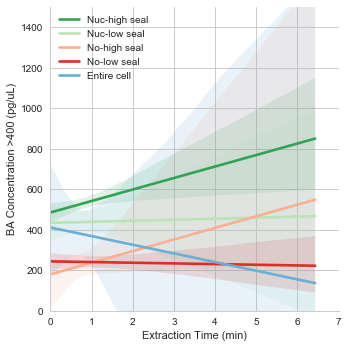

In [21]:
lm = sns.lmplot(x = 'ext_dur', 
                y = 'BA_conc', 
                data = ps_df, 
                hue = 'post_patch',
                hue_order = ['Nuc-high seal', 'Nuc-low seal', 'No-high seal', 'No-low seal','Entire cell'],
                palette = ['#31a354', '#bae4b3', '#fcae91', '#de2d26', '#6baed6'],
                scatter = False,
                legend = False)

axes = lm.axes #Set array of axes
axes[0,0].set_ylim(0,1500)
axes[0,0].set_xlim(0, 7)

lm.set(xlabel = "Extraction Time (min)", ylabel = "BA Concentration >400 (pg/uL)")
lm.ax.legend(loc = 2) #Legend corresponds to quadrant

plt.tight_layout() #Moves axes into place if out of frame

### Seaborn plot: Concentration vs Retraction Duration by Post Patch Outcomes

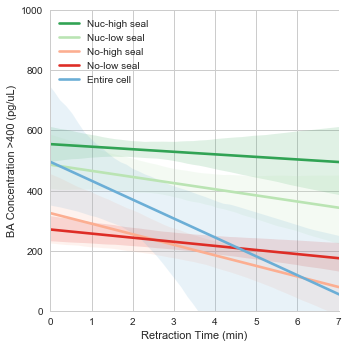

In [22]:
lm = sns.lmplot(x = 'ret_dur', 
                y = 'BA_conc', 
                data = ps_df, 
                hue = 'post_patch',
                hue_order = ['Nuc-high seal', 'Nuc-low seal', 'No-high seal', 'No-low seal','Entire cell'],
                palette = ['#31a354', '#bae4b3', '#fcae91', '#de2d26', '#6baed6'],
                scatter = False,
                legend = False)

axes = lm.axes #Set array of axes
axes[0,0].set_ylim(0,1000)
axes[0,0].set_xlim(0, 7)

lm.set(xlabel = "Retraction Time (min)", ylabel = "BA Concentration >400 (pg/uL)")
lm.ax.legend(loc = 2) #Legend corresponds to quadrant

plt.tight_layout() #Moves axes into place if out of frame

### Seaborn plot: Concentration vs Recording Duration by Post Patch Outcomes

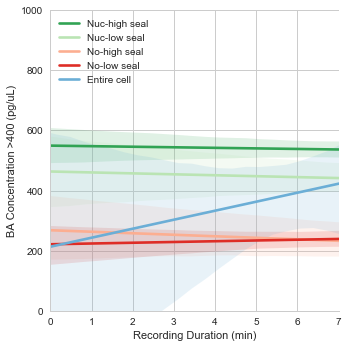

In [23]:
lm = sns.lmplot(x = 'rec_dur', 
                y = 'BA_conc', 
                data = ps_df, 
                hue = 'post_patch',
                hue_order = ['Nuc-high seal', 'Nuc-low seal', 'No-high seal', 'No-low seal','Entire cell'],
                palette = ['#31a354', '#bae4b3', '#fcae91', '#de2d26', '#6baed6'],
                scatter = False,
                legend = False)

axes = lm.axes #Set array of axes
axes[0,0].set_ylim(0,1000)
axes[0,0].set_xlim(0, 7)

lm.set(xlabel = "Recording Duration (min)", ylabel = "BA Concentration >400 (pg/uL)")
lm.ax.legend(loc = 2) #Legend corresponds to quadrant

plt.tight_layout() #Moves axes into place if out of frame

### Seaborn plot: Concentration vs Patch Duration by Post Patch Outcomes

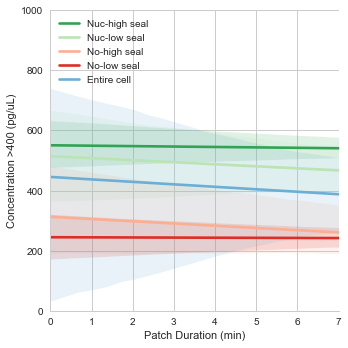

In [24]:
lm = sns.lmplot(x = 'patch_dur', 
                y = 'BA_conc', 
                data = ps_df, 
                hue = 'post_patch',
                hue_order = ['Nuc-high seal', 'Nuc-low seal', 'No-high seal', 'No-low seal','Entire cell'],
                palette = ['#31a354', '#bae4b3', '#fcae91', '#de2d26', '#6baed6'],
                scatter = False,
                legend = False)

axes = lm.axes #Set array of axes
axes[0,0].set_ylim(0,1000) #Sets axes as center coordinate & y limits
axes[0,0].set_xlim(0, 7)

lm.set(xlabel = "Patch Duration (min)", ylabel = "Concentration >400 (pg/uL)") #Sets x and y axis labels 
lm.ax.legend(loc = 2) #Legend corresponds to quadrant

plt.tight_layout() #Moves axes into place if out of frame
#sns.despine() #Gets rid of the top and right spine on plot
#plt.savefig("conc_vs_extraction_seaborn.png",dpi=300) #Saves plot as .png